In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xrp_open.csv')
print(df)

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['open']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_open.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,0.322593,0.317439,0.321078,0.320790,363940431,0.320790,0.005154,0.326430,0.333398,0.343423,0.004046,0.019639
21,21,2019-01-22,0.321078,0.313455,0.319566,0.319491,434125854,0.319491,0.007623,0.325376,0.330090,0.341227,0.004784,0.019605
22,22,2019-01-23,0.320303,0.314923,0.316416,0.316492,375671478,0.316492,0.005380,0.323480,0.326158,0.338461,0.005382,0.018754
23,23,2019-01-24,0.318896,0.314433,0.317859,0.317598,344960253,0.317598,0.004463,0.321860,0.325199,0.336466,0.005072,0.018603
24,24,2019-01-25,0.319069,0.313824,0.317260,0.317165,360076505,0.317165,0.005245,0.320654,0.324074,0.334605,0.005010,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,0.390547,0.374133,0.378507,0.378477,953355531,0.378477,0.016414,0.390655,0.387824,0.390458,0.006728,0.010027
1516,1516,2023-02-25,0.379419,0.372250,0.378085,0.378085,552223148,0.378085,0.007169,0.388296,0.387403,0.388878,0.007907,0.009161
1517,1517,2023-02-26,0.380606,0.375420,0.378005,0.378041,441815645,0.378041,0.005186,0.387100,0.387600,0.387880,0.008825,0.009149
1518,1518,2023-02-27,0.380042,0.372158,0.379121,0.379115,1049508853,0.379115,0.007884,0.384329,0.388137,0.387227,0.007603,0.009266


In [4]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.3)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

450
(1043, 7, 9) (1043, 1) (450, 7, 9) (450, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 51s 19ms/step - loss: 0.0135
Epoch 2/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0054
Epoch 3/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 4/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0042
Epoch 5/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0047
Epoch 6/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0039
Epoch 7/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0042
Epoch 8/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 9/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 10/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 1s 29ms/step - loss: 0.0026
Epoch 12/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0030
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_test)
# predict_price = scala_y.inverse_transform(predict_price)
# y_train_price = scala_y.inverse_transform(y_train)

# error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
# error['error_price'] = error['predict_price'] - error['y_train_price']
# print(error)

15/15 [==============================] - 4s 4ms/step


In [7]:
predict_price = model.predict(x_test)
print(predict_price)

15/15 [==============================] - 0s 5ms/step
[[0.42009842]
 [0.42708924]
 [0.42711735]
 [0.44656998]
 [0.44436523]
 [0.4154019 ]
 [0.4299961 ]
 [0.43075767]
 [0.40422937]
 [0.40579382]
 [0.41726074]
 [0.41113022]
 [0.40834957]
 [0.41719624]
 [0.4253264 ]
 [0.45314884]
 [0.48688814]
 [0.5065862 ]
 [0.5383138 ]
 [0.5057861 ]
 [0.5037234 ]
 [0.50379944]
 [0.5067092 ]
 [0.47477028]
 [0.4517329 ]
 [0.45278272]
 [0.44697848]
 [0.45293823]
 [0.45531502]
 [0.43832314]
 [0.4365439 ]
 [0.4079816 ]
 [0.4016141 ]
 [0.39417028]
 [0.38391373]
 [0.38314205]
 [0.36972174]
 [0.38208142]
 [0.40134642]
 [0.3889514 ]
 [0.39162365]
 [0.39565903]
 [0.39586034]
 [0.38785   ]
 [0.3826725 ]
 [0.37317166]
 [0.36999327]
 [0.32824916]
 [0.29651797]
 [0.3103245 ]
 [0.29424617]
 [0.29833734]
 [0.30488363]
 [0.28300005]
 [0.29053873]
 [0.29245776]
 [0.28412643]
 [0.28568417]
 [0.2923345 ]
 [0.28103858]
 [0.28010753]
 [0.30907997]
 [0.3196923 ]
 [0.3316788 ]
 [0.41741416]
 [0.46049505]
 [0.4787116 ]
 [0.47175

In [8]:



# predict_error = elasticnet.predict(predict_price)
# index=0
predict_price = scala_y.inverse_transform(predict_price)
# for error in predict_error:
#     predict_price[index]+=error
#     index+=1
# print(predict_price)



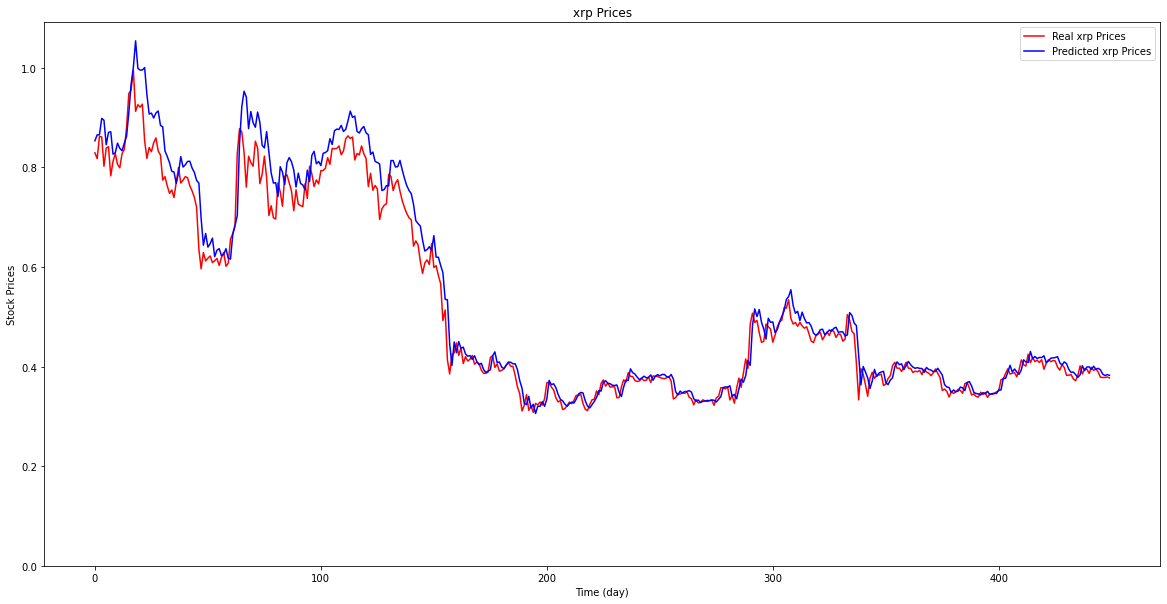

In [9]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real xrp Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted xrp Prices")
plt.title(f"xrp Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [10]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.03
MAPE: 4.39%
MSE: 0.00
RMSE: 0.04
R2: 0.96


In [11]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [12]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))